In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [13]:
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
config

{'raw': 'data/raw',
 'processed': 'data/processed',
 'input': '_chat.txt',
 'current': 'whatsapp-20250910-005041-dac-cleaned.parq',
 'current_1': 'whatsapp-20250910-002822-maap-cleaned.parq',
 'current_2a': 'whatsapp-20250910-004727-golf-cleaned.parq',
 'current_2b': 'whatsapp-20250910-012654-voorganger-golf-cleaned.parq',
 'current_3': 'whatsapp-20250910-005041-dac-cleaned.parq',
 'current_4': 'whatsapp-20250910-012135-til-cleaned.parq',
 'inputpath': 'whatsapp-20250910-002822-maap-cleaned.csv',
 'datetime_format': '%d-%m-%Y, %H:%M:%S',
 'drop_authors': []}

In [14]:
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )

Lets load the data

In [15]:
df = pd.read_parquet(datafile)
df

,timestamp,author,message,has_emoji
0,2014-11-16 14:00:43+00:00,Irene Bienema,‎Irene Bienema heeft deze groep gemaakt,False
1,2017-01-04 11:06:46+00:00,DAC cie,‎Irene Bienema heeft je toegevoegd,False
2,2017-01-04 19:42:06+00:00,DAC cie,‎Berichten en oproepen worden end-to-end versl...,False
3,2017-01-04 19:42:35+00:00,Anthony van Tilburg,Gelukt! Ik ben weer aangesloten!,False
4,2017-01-04 19:42:57+00:00,Wil,👍,True
...,...,...,...,...
2525,2025-08-25 17:19:56+00:00,Anthony van Tilburg,Morgen koffie om 11:30 uur op het terras van ZS?,False
2526,2025-08-25 17:20:53+00:00,Nico Dofferhoff,👍☕️,True
2527,2025-08-25 17:21:34+00:00,Hieke Heusden van,Prima!,False
2528,2025-08-25 17:53:48+00:00,Herma Hollander,Lekker!,False


Let's extract some more info from the timestamp:

In [16]:
df["date"] = df["timestamp"].dt.date
df["isoweek"] = df["timestamp"].dt.isocalendar().week
df["year-week"] = df["timestamp"].dt.strftime("%Y-%W")
df.head()

,timestamp,author,message,has_emoji,date,isoweek,year-week
0,2014-11-16 14:00:43+00:00,Irene Bienema,‎Irene Bienema heeft deze groep gemaakt,False,2014-11-16,46,2014-45
1,2017-01-04 11:06:46+00:00,DAC cie,‎Irene Bienema heeft je toegevoegd,False,2017-01-04,1,2017-01
2,2017-01-04 19:42:06+00:00,DAC cie,‎Berichten en oproepen worden end-to-end versl...,False,2017-01-04,1,2017-01
3,2017-01-04 19:42:35+00:00,Anthony van Tilburg,Gelukt! Ik ben weer aangesloten!,False,2017-01-04,1,2017-01
4,2017-01-04 19:42:57+00:00,Wil,👍,True,2017-01-04,1,2017-01


In [18]:
topk = list(df.author.unique())
topk

['Irene Bienema',
 'DAC cie',
 'Anthony van Tilburg',
 'Wil',
 'Loek Laan',
 'Nico Dofferhoff',
 'Herma Hollander',
 'Hieke Heusden van']

Now, we can group by the isoweeks, for example. Let's reindex in order to fill the missing weeks.

In [19]:
df = df.drop(index=[0])

In [20]:
p = df.groupby("year-week").count()
p.head()

,timestamp,author,message,has_emoji,date,isoweek
year-week,,,,,,
2017-01,5,5,5,5,5,5
2017-03,14,14,14,14,14,14
2017-04,2,2,2,2,2,2
2017-13,3,3,3,3,3,3
2017-14,8,8,8,8,8,8


In [21]:
min_ts = df["timestamp"].min()
max_ts = df["timestamp"].max()
new_index = pd.date_range(
    start=min_ts, end=max_ts, freq="W", name="year-week"
).strftime("%Y-%W")
p = p.reindex(new_index, fill_value=0)
p.head()

,timestamp,author,message,has_emoji,date,isoweek
year-week,,,,,,
2017-01,5,5,5,5,5,5
2017-02,0,0,0,0,0,0
2017-03,14,14,14,14,14,14
2017-04,2,2,2,2,2,2
2017-05,0,0,0,0,0,0


Text(0.5, 1.0, 'Messages over time')

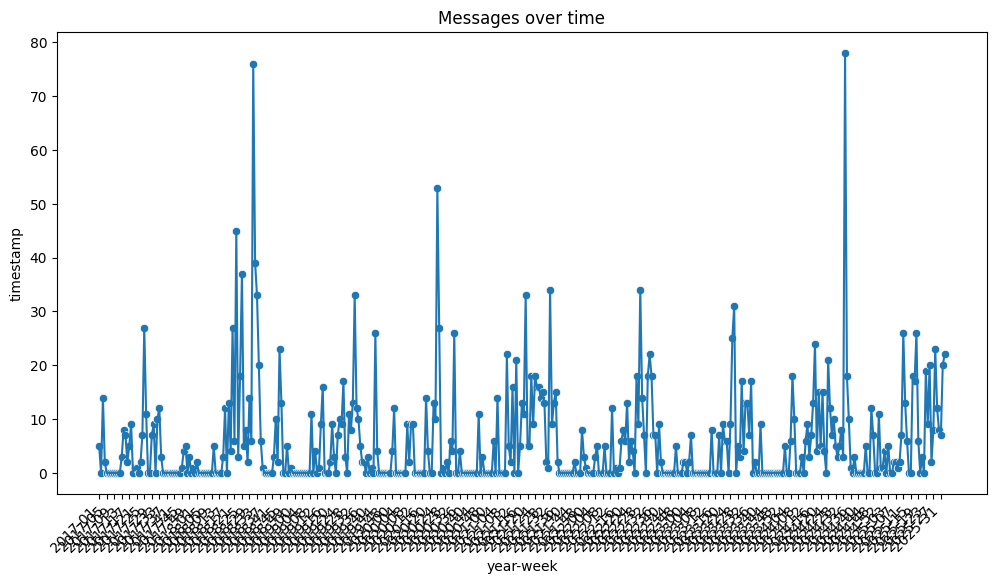

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(data=p, x=p.index, y="timestamp", ax=ax)
p["moving_avg"] = p["timestamp"].rolling(window=1).mean()
sns.lineplot(data=p, x=p.index, y="moving_avg", ax=ax)

interval = 4
xticks = p.index[::interval]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=45, ha="right")
plt.title("Messages over time")

Try to play with the colors. Make sure adding colors conveys a message, and isnt randomly adding colors. Probaly, a scatterplot and lineplot are not the best way to show the count of messages per author, per week, for your data, so you might need to modify that. It might not even be useful for your data to do this (eg because you have too many authors).

The main goal here is to find some way to visualise the count over time, per author, and to give you some starting point if that is relevant for your dataset.

In [23]:
# keep only topk authors

p = df[df["author"].isin(topk)].groupby(["author", "year-week"]).count()
# p = df.groupby(["author", "year-week"]).count()
p

timestamp  message  has_emoji  date  isoweek
author              year-week                                              
Anthony van Tilburg 2017-01            1        1          1     1        1
                    2017-15            1        1          1     1        1
                    2017-17            2        2          2     2        2
                    2017-23            1        1          1     1        1
                    2017-24            1        1          1     1        1
...                                  ...      ...        ...   ...      ...
Wil                 2017-03            1        1          1     1        1
                    2017-14            1        1          1     1        1
                    2017-16            1        1          1     1        1
                    2017-18            3        3          3     3        3
                    2017-24            1        1          1     1        1

[890 rows x 5 columns]

In [24]:
# authors = df["author"].unique()
multi_index = pd.MultiIndex.from_product(
    [topk, new_index], names=["author", "year-week"]
)
p = p.reindex(multi_index, fill_value=0)
p

timestamp  message  has_emoji  date  isoweek
author            year-week                                              
Irene Bienema     2017-01            0        0          0     0        0
                  2017-02            0        0          0     0        0
                  2017-03            3        3          3     3        3
                  2017-04            0        0          0     0        0
                  2017-05            0        0          0     0        0
...                                ...      ...        ...   ...      ...
Hieke Heusden van 2025-29            1        1          1     1        1
                  2025-30            1        1          1     1        1
                  2025-31            0        0          0     0        0
                  2025-32            4        4          4     4        4
                  2025-33            3        3          3     3        3

[3608 rows x 5 columns]

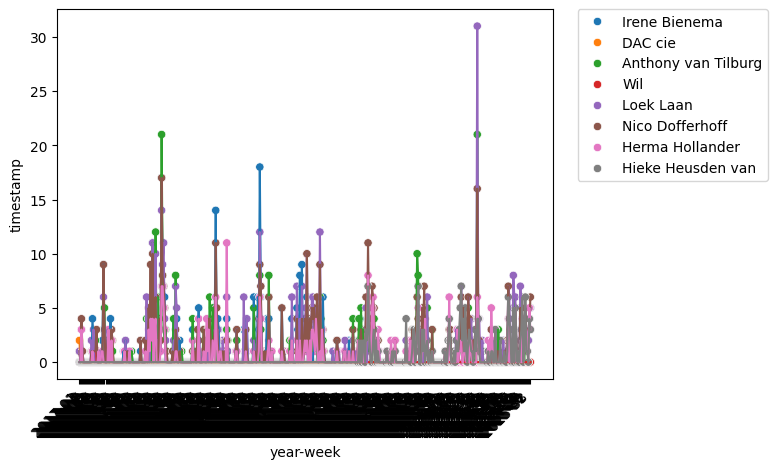

In [25]:

# put legend outside the plot
sns.scatterplot(data=p, x="year-week", y="timestamp", hue="author", legend=True)
sns.lineplot(data=p, x="year-week", y="timestamp", legend=False, hue="author")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.xticks(rotation=45, ha="right");

In [26]:
df["day_of_week"] = df["timestamp"].dt.day_name()
df_agg = df.groupby(["date", "day_of_week"]).size().reset_index(name="message_count")
df_agg

,date,day_of_week,message_count
0,2017-01-04,Wednesday,5
1,2017-01-17,Tuesday,3
2,2017-01-18,Wednesday,2
3,2017-01-19,Thursday,9
4,2017-01-23,Monday,2
...,...,...,...
498,2025-08-15,Friday,9
499,2025-08-16,Saturday,1
500,2025-08-20,Wednesday,16
501,2025-08-21,Thursday,6


Sometimes, you want to group the timeseries in clusters, eg per day of the week (of per month, or per year, etc). Facetgrid is a nice way to do this.

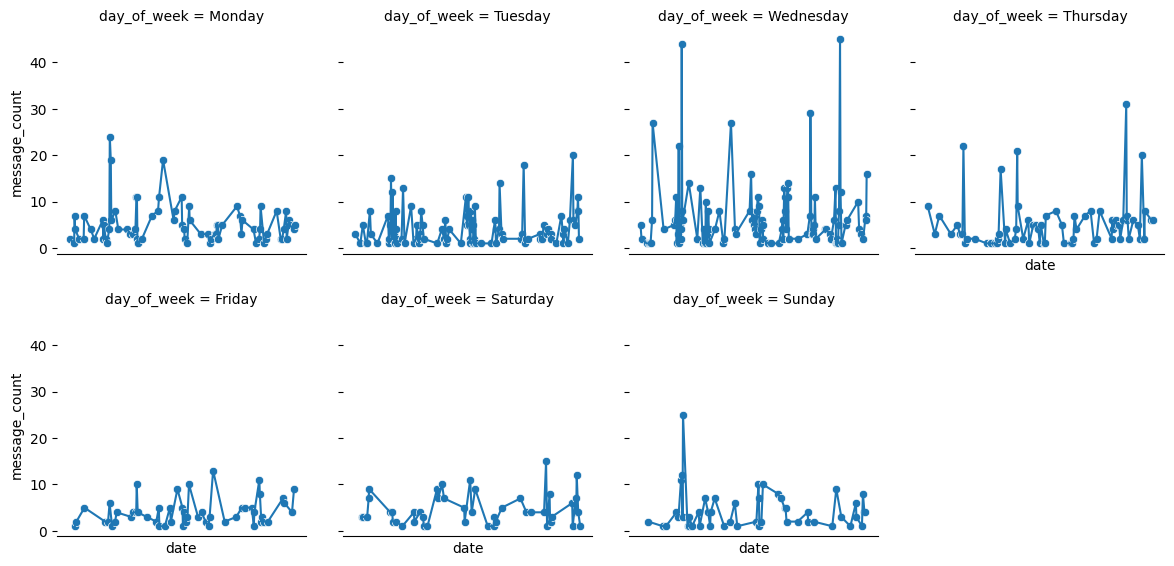

In [27]:
# Set the order of the days of the week
days_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]

# Create a FacetGrid to plot the line plots for each day of the week
g = sns.FacetGrid(df_agg, col="day_of_week", col_wrap=4, height=3, col_order=days_order)
g.map(sns.scatterplot, "date", "message_count")
g.map(sns.lineplot, "date", "message_count")
g.set(xticks=[])
g.despine(left=True, bottom=False)

Another nice plot is the area plot. Plotly has a nice version if this one.

In [ ]:
import plotly.express as px

# first count the number for every category, for every date
p = df.groupby(["date", "timestamp_category"]).size().reset_index(name="message_count")
# then, make the count cumulative for every category
p["cumulative_count"] = p.groupby("timestamp_category")["message_count"].cumsum()

fig = px.area(
    p,
    x="date",
    y="cumulative_count",
    color="timestamp_category",
    line_group="timestamp_category",
    labels={"cumulative_count": "Cumulative Message Count"},
)
fig.show()

ValueError: Value of 'line_group' is not the name of a column in 'data_frame'. Expected one of ['date', 'day_of_week', 'message_count', 'cumulative_count'] but received: timestamp_category

# Code for two authors
I have experimented with two authors, and explored the question "who is the first (or last) of the day to send a message?". I didnt tweak this for groupchats.

In [21]:
df_grouped = df.groupby("date").agg(
    {
        "timestamp": ["min", "max"],
        "author": ["first", "last"],
    }
)
df_grouped.columns = df_grouped.columns.map("_".join)
df_grouped

,timestamp_min,timestamp_max,author_first,author_last
date,,,,
2017-03-31,2017-03-31 11:58:33+00:00,2017-03-31 11:58:33+00:00,Phons Berkemeijer,Phons Berkemeijer
2018-05-01,2018-05-01 21:31:07+00:00,2018-05-01 21:31:07+00:00,Phons Berkemeijer,Phons Berkemeijer
2019-04-07,2019-04-07 19:35:25+00:00,2019-04-07 19:35:25+00:00,Phons Berkemeijer,Phons Berkemeijer
2019-08-04,2019-08-04 13:39:20+00:00,2019-08-04 13:39:20+00:00,Phons Berkemeijer,Phons Berkemeijer
2019-08-12,2019-08-12 12:38:17+00:00,2019-08-12 14:11:41+00:00,Anja Berkemeijer,Anja Berkemeijer
...,...,...,...,...
2025-08-03,2025-08-03 17:30:39+00:00,2025-08-03 21:56:07+00:00,Phons Berkemeijer,Phons Berkemeijer
2025-08-04,2025-08-04 17:40:05+00:00,2025-08-04 23:22:25+00:00,Phons Berkemeijer,Anja Berkemeijer
2025-08-06,2025-08-06 12:38:23+00:00,2025-08-06 15:19:25+00:00,Anja Berkemeijer,Phons Berkemeijer


In [22]:
df_grouped["timestamp_max_shifted"] = df_grouped["timestamp_max"].shift()

# Calculate the time difference
df_grouped["time_difference"] = (
    df_grouped["timestamp_min"] - df_grouped["timestamp_max_shifted"]
)
df_grouped

,timestamp_min,timestamp_max,author_first,author_last,timestamp_max_shifted,time_difference
date,,,,,,
2017-03-31,2017-03-31 11:58:33+00:00,2017-03-31 11:58:33+00:00,Phons Berkemeijer,Phons Berkemeijer,NaT,NaT
2018-05-01,2018-05-01 21:31:07+00:00,2018-05-01 21:31:07+00:00,Phons Berkemeijer,Phons Berkemeijer,2017-03-31 11:58:33+00:00,396 days 09:32:34
2019-04-07,2019-04-07 19:35:25+00:00,2019-04-07 19:35:25+00:00,Phons Berkemeijer,Phons Berkemeijer,2018-05-01 21:31:07+00:00,340 days 22:04:18
2019-08-04,2019-08-04 13:39:20+00:00,2019-08-04 13:39:20+00:00,Phons Berkemeijer,Phons Berkemeijer,2019-04-07 19:35:25+00:00,118 days 18:03:55
2019-08-12,2019-08-12 12:38:17+00:00,2019-08-12 14:11:41+00:00,Anja Berkemeijer,Anja Berkemeijer,2019-08-04 13:39:20+00:00,7 days 22:58:57
...,...,...,...,...,...,...
2025-08-03,2025-08-03 17:30:39+00:00,2025-08-03 21:56:07+00:00,Phons Berkemeijer,Phons Berkemeijer,2025-08-02 18:12:02+00:00,0 days 23:18:37
2025-08-04,2025-08-04 17:40:05+00:00,2025-08-04 23:22:25+00:00,Phons Berkemeijer,Anja Berkemeijer,2025-08-03 21:56:07+00:00,0 days 19:43:58
2025-08-06,2025-08-06 12:38:23+00:00,2025-08-06 15:19:25+00:00,Anja Berkemeijer,Phons Berkemeijer,2025-08-04 23:22:25+00:00,1 days 13:15:58


In [23]:
mapping = {
    v: ((1 - k) * -1 + (k * 1))
    for k, v in enumerate(df_grouped["author_first"].unique())
}
# this only works with two authors
# mapping = {'author1': 1, 'author2' : -1}
mapping

{'Phons Berkemeijer': -1,
 'Anja Berkemeijer': 1,
 'Madeleine': 3,
 'Anthony van Tilburg': 5}

In [24]:
mapping.items()

dict_items([('Phons Berkemeijer', -1), ('Anja Berkemeijer', 1), ('Madeleine', 3), ('Anthony van Tilburg', 5)])

In [25]:
df_grouped["last_message"] = df_grouped["author_last"].map(mapping)
df_grouped["first_message"] = df_grouped["author_first"].map(mapping)
df_grouped["last_balance"] = df_grouped["last_message"].cumsum()
df_grouped["first_balance"] = df_grouped["first_message"].cumsum()

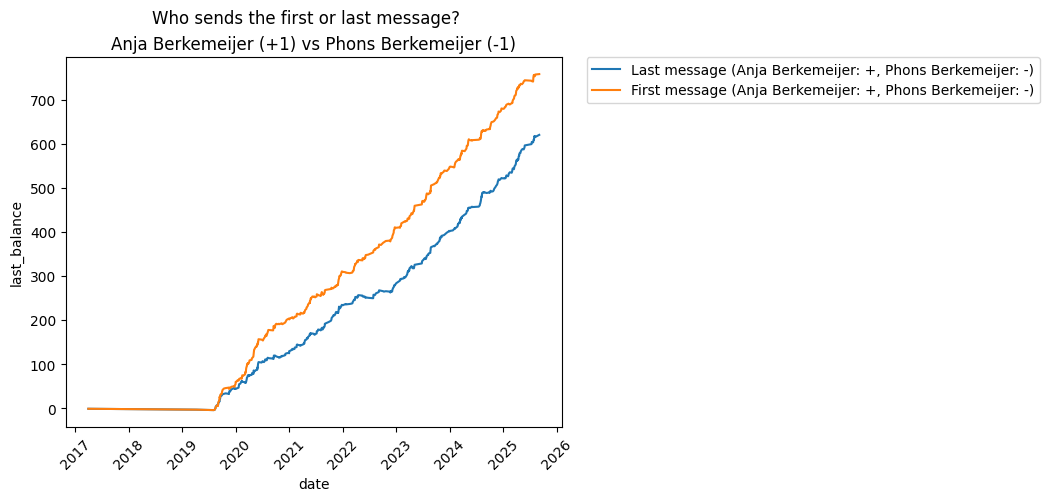

In [26]:
# Get the actual author names from the mapping dictionary
author_positive = [k for k, v in mapping.items() if v == 1][0]
author_negative = [k for k, v in mapping.items() if v == -1][0]

# Create more descriptive labels
sns.lineplot(
    data=df_grouped,
    x="date",
    y="last_balance",
    label=f"Last message ({author_positive}: +, {author_negative}: -)",
)
sns.lineplot(
    data=df_grouped,
    x="date",
    y="first_balance",
    label=f"First message ({author_positive}: +, {author_negative}: -)",
)

# Adjust title to use actual author names
plt.suptitle("Who sends the first or last message?")
plt.xticks(rotation=45)
plt.title(f"{author_positive} (+1) vs {author_negative} (-1)")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0)

In [27]:
df_grouped.head()

,timestamp_min,timestamp_max,author_first,author_last,timestamp_max_shifted,time_difference,last_message,first_message,last_balance,first_balance
date,,,,,,,,,,
2017-03-31,2017-03-31 11:58:33+00:00,2017-03-31 11:58:33+00:00,Phons Berkemeijer,Phons Berkemeijer,NaT,NaT,-1,-1,-1,-1
2018-05-01,2018-05-01 21:31:07+00:00,2018-05-01 21:31:07+00:00,Phons Berkemeijer,Phons Berkemeijer,2017-03-31 11:58:33+00:00,396 days 09:32:34,-1,-1,-2,-2
2019-04-07,2019-04-07 19:35:25+00:00,2019-04-07 19:35:25+00:00,Phons Berkemeijer,Phons Berkemeijer,2018-05-01 21:31:07+00:00,340 days 22:04:18,-1,-1,-3,-3
2019-08-04,2019-08-04 13:39:20+00:00,2019-08-04 13:39:20+00:00,Phons Berkemeijer,Phons Berkemeijer,2019-04-07 19:35:25+00:00,118 days 18:03:55,-1,-1,-4,-4
2019-08-12,2019-08-12 12:38:17+00:00,2019-08-12 14:11:41+00:00,Anja Berkemeijer,Anja Berkemeijer,2019-08-04 13:39:20+00:00,7 days 22:58:57,1,1,-3,-3


In [28]:
def time_to_decimal(time_obj):
    return time_obj.hour + time_obj.minute / 60 + time_obj.second / 3600


df_grouped["decimal_first_time"] = df_grouped.timestamp_min.apply(time_to_decimal)
df_grouped["decimal_last_time"] = df_grouped.timestamp_max.apply(time_to_decimal)

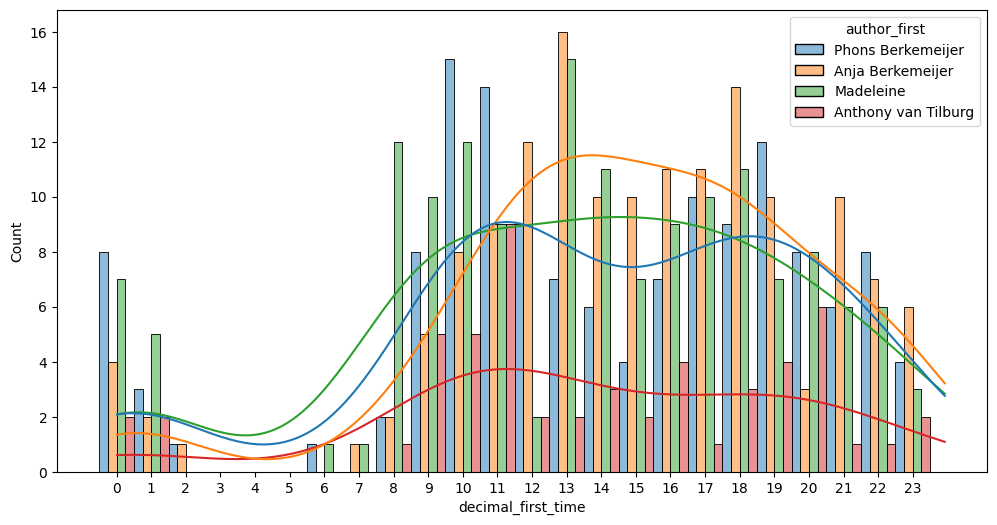

In [29]:
fig, ax = plt.subplots(figsize=(12, 6))
center = [t - 0.5 for t in range(0, 25)]
sns.histplot(
    data=df_grouped,
    x="decimal_first_time",
    hue="author_first",
    common_norm=False,
    fill=True,
    bins=center,
    multiple="dodge",
    kde=True,
    ax=ax,
)
ax.set_xticks(range(0, 24));

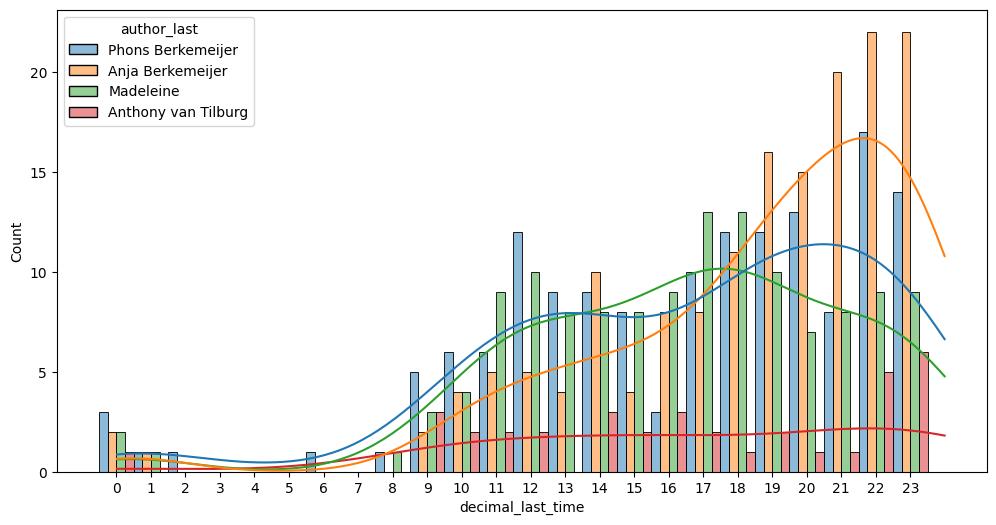

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))
center = [t - 0.5 for t in range(0, 25)]
sns.histplot(
    data=df_grouped,
    x="decimal_last_time",
    hue="author_last",
    common_norm=False,
    fill=True,
    bins=center,
    multiple="dodge",
    kde=True,
    ax=ax,
)
ax.set_xticks(range(0, 24));

In [31]:
def decimal_delta(td):
    if td == 0:
        return 0
    return td.total_seconds() / 3600


df["next_author"] = df.author.shift(-1)
df["next_timestamp"] = df.timestamp.shift(-1)
df["reaction_time"] = df.next_timestamp - df.timestamp
df["decimal_reaction_time"] = df.reaction_time.apply(decimal_delta)
df["reply"] = df.apply(lambda x: x.author != x.next_author, axis=1)
df.head()

,timestamp,author,message,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week,date,isoweek,year-week,next_author,next_timestamp,reaction_time,decimal_reaction_time,reply
1,2017-03-31 11:58:33+00:00,Phons Berkemeijer,‎Locatie: https://maps.google.com/?q=51.378368...,False,True,2972,True,worktimes,11:58:33,Friday,2017-03-31,13,2017-13,Phons Berkemeijer,2018-05-01 21:31:07+00:00,396 days 09:32:34,9513.542778,False
2,2018-05-01 21:31:07+00:00,Phons Berkemeijer,"‎Dit bericht is verwijderd. ‎[13-05-2018, 15:0...",False,True,4997,False,evening,21:31:07,Tuesday,2018-05-01,18,2018-18,Phons Berkemeijer,2019-04-07 19:35:25+00:00,340 days 22:04:18,8182.071667,False
3,2019-04-07 19:35:25+00:00,Phons Berkemeijer,"‎Dit bericht is verwijderd. ‎[31-05-2019, 19:2...",False,True,1226,False,evening,19:35:25,Sunday,2019-04-07,14,2019-13,Phons Berkemeijer,2019-08-04 13:39:20+00:00,118 days 18:03:55,2850.065278,False
4,2019-08-04 13:39:20+00:00,Phons Berkemeijer,‎Phons Berkemeijer heeft de groepsafbeelding g...,False,True,54,False,worktimes,13:39:20,Sunday,2019-08-04,31,2019-30,Anja Berkemeijer,2019-08-12 12:38:17+00:00,7 days 22:58:57,190.982500,True
5,2019-08-12 12:38:17+00:00,Anja Berkemeijer,Obon ipv gasly 🙈 Ja dat gaat het verschil maken😏,True,True,48,False,worktimes,12:38:17,Monday,2019-08-12,33,2019-32,Madeleine,2019-08-12 14:06:04+00:00,0 days 01:27:47,1.463056,True


Text(0.5, 1.0, 'Who is the fastest in responding?')

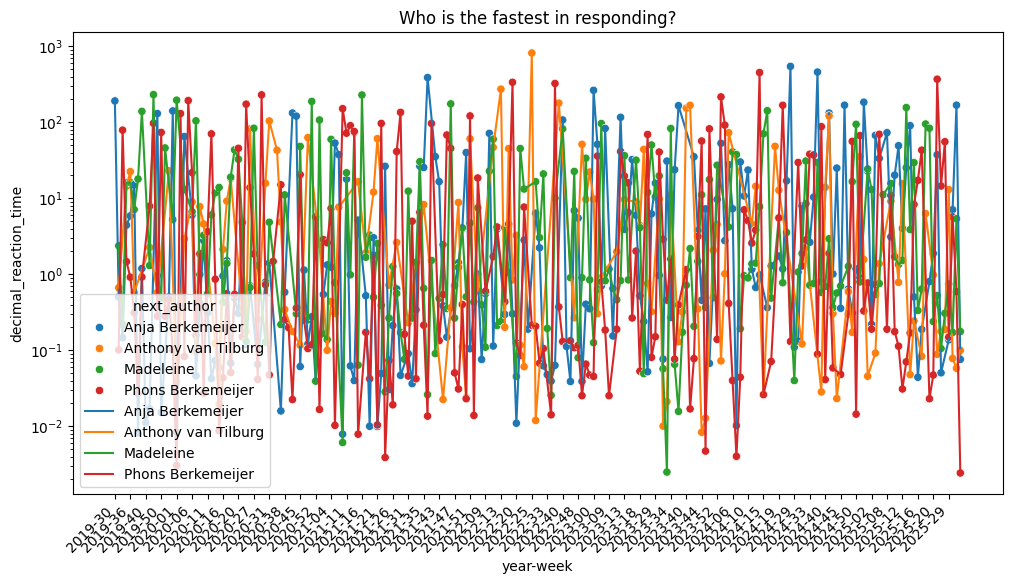

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
p = (
    df[df.reply]
    .groupby(["year-week", "next_author"])
    .agg({"decimal_reaction_time": "mean"})
)
sns.scatterplot(
    data=p, x="year-week", y="decimal_reaction_time", hue="next_author", ax=ax
)
sns.lineplot(data=p, x="year-week", y="decimal_reaction_time", hue="next_author", ax=ax)
plt.yscale("log")
interval = 4
xticks = p.reset_index()["year-week"].unique()[::interval]
# xticks = p.index[::interval]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=45, ha="right")
plt.title("Who is the fastest in responding?")

(0.0, 24.0)

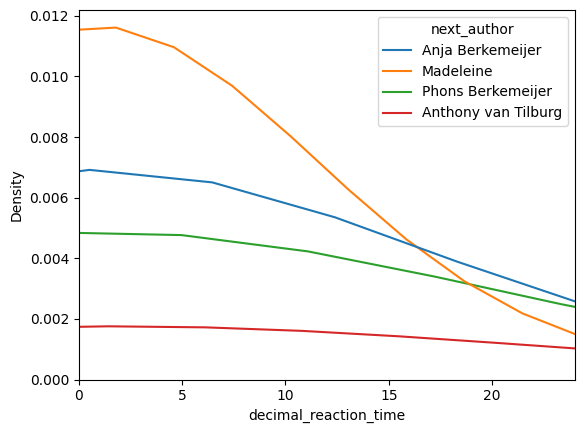

In [33]:
p = df[df.reply]

sns.kdeplot(data=p, x="decimal_reaction_time", hue="next_author")
plt.xlim((0, 24))
# uncomment log if necessary
# plt.yscale('log')
